<a href="https://colab.research.google.com/github/A-Kester/csci-451/blob/main/docs/live-notebooks/02-signal-noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data = Signal + Noise

Introducing data-generating distributions for machine learning

## Introduction: Data, Signal, and Noise

In these notes, we’ll expand on the following idea:

> Machine learning is the science and practice of building algorithms that distinguish between signal and noise in real-world data.

Let’s start by building up a simple data set that contains signal and noise:

In [2]:
import torch
from matplotlib import pyplot as plt
scatterplot_kwargs = dict(color = "black", label = "data", facecolors = "none", s = 40, alpha = 0.6)

In [4]:
n_points = 20
x = torch.linspace(0, 10, n_points)
signal = 2.0*x + 1.0
noise = torch.randn(n_points) * 3.0

y = signal + noise

tensor([-0.2727,  4.3752,  1.7298,  9.3419,  0.9056,  2.5563, 11.4234,  9.5382,
         7.6528, 10.2212, 15.9914, 11.3979, 16.1312, 16.6109, 13.6196, 21.9764,
        15.7592, 18.1813, 26.8398, 23.4479])

Figure 1: An illustrative decomposition of a data set (points) into a hypothesized underlying signal (dashed line) and noise (red segments).

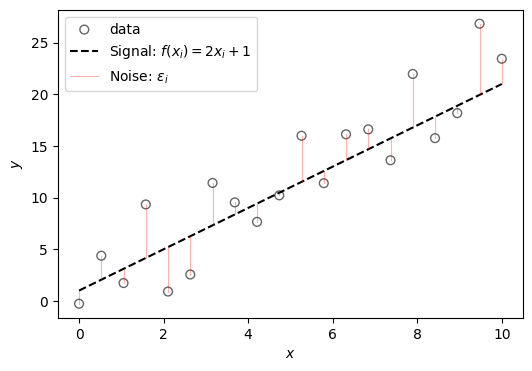

In [5]:
# Plot residual segments
fig, ax = plt.subplots(figsize = (6, 4))
ax.scatter(x.numpy(), y.numpy(), **scatterplot_kwargs)
ax.plot(x.numpy(), signal.numpy(), color = "black", linestyle = "--", label = r"Signal: $f(x_i) = 2x_i + 1$")
for i in range(n_points):
    if i == 0:
        ax.plot([x[i].item(), x[i].item()], [signal[i].item(), y[i].item()], color = "red", alpha = 0.3, linewidth = 0.8, label = r"Noise: $\epsilon_i$")
    else:
        ax.plot([x[i].item(), x[i].item()], [signal[i].item(), y[i].item()], color = "red", alpha = 0.3, linewidth = 0.8)
ax.set(xlabel = r"$x$", ylabel = r"$y$")
plt.legend()

We can think of this data as consisting of two components: a **signal** expressed by a relationship $y \approx f(x)$ (in this case $f(x) = 2x + 1$), and some **noise** that partially obscures this relationship. Schematically, we can write this relationship as:

$$
\begin{aligned}
    y_i = f(x_i) + \epsilon_i\;,
\end{aligned}
 \qquad(1)$$

which says that the $i$th value of the target is equal to some function $f(x_i)$ of the input variable $x_i$, plus some random noise term $\epsilon_i$.

## Overfitting

It’s important to emphasize here that the thing we want to learn is *not* the individual targets $y_i$, but rather the underlying function $f(x)$. To see why, let’s consider an example of what goes wrong if we try to learn the targets $y_i$ exactly. This is called *interpolation*, and is illustrated by <a href="#fig-interpolation" class="quarto-xref">Figure 2</a>:

Figure 2: A function which exactly interpolates the data, perfectly fitting both signal and noise.

In [ ]:
from scipy import interpolate
# Create an interpolating function
f_interp = interpolate.interp1d(x.numpy(), y.numpy(), kind='cubic')
x_dense = torch.linspace(0, 10, 100)
y_interp = f_interp(x_dense.numpy())

fig, ax = plt.subplots(figsize = (6, 4))
ax.scatter(x.numpy(), y.numpy(), **scatterplot_kwargs)
ax.plot(x_dense.numpy(), y_interp, color = "red", linestyle = "--", label = "interpolating fit", zorder = -10)
ax.set(xlabel = r"$x$", ylabel = r"$y$")
plt.legend()
plt.show()

The problem with interpolation is that while we have perfectly fit our training data, we have not learned the underlying *signal* $f(x)$. If we were to generate new data with the same signal but with different noise, we would likely find that our interpolating function doesn’t actually make very good predictions about that data at all: many of its bends and wiggles don’t have any correspondence to features in the new data.

Figure 3: New data plotted alongside the interpolating fit from the previous figure.

In [ ]:
# Generate new data
y_new = 2.0 * x_dense + 1.0 + torch.randn(100) * 3.0
fig, ax = plt.subplots(figsize = (6, 4))
ax.scatter(x_dense.numpy(), y_new.numpy(), **scatterplot_kwargs)
ax.plot(x_dense.numpy(), y_interp, color = "red", linestyle = "--", label = "interpolating fit", zorder = -10)
ax.set(xlabel = r"$x$", ylabel = r"$y$")
plt.legend()
plt.show()

We observe a number of irrelevant fluctuations in the interpolating fit that do not correspond to the underlying pattern. This phenomenon is called **overfitting**: by trying to fit the noise in our training data, we have failed to learn the true signal. We’ll learn how to quantify overfitting once we begin to study measures of model quality.

## Modeling the Noise

If we want to learn the signal $f$ in <a href="#eq-signal-plus-noise" class="quarto-xref">Equation 1</a>, it’s helpful to learn how to talk mathematically about the noise term $\epsilon_i$. To do this, we need to step into the language of probability theory. Our standing assumption will be that the noise terms $\epsilon_i$ are *random variables* drawn independently and identically-distributed from some probability distribution. This means that each time we observe a new data point, we get a different value of $\epsilon_i$ drawn from the same distribution, without any influence from other values of $\epsilon_j$ for $j \neq i$.

The noise distribution we will usually consider is the Gaussian distribution:

<span class="theorem-title">**Definition 1 (Gaussian (Normal) Distribution)**</span> A random variable $\epsilon$ has a Gaussian distribution with *parameters* mean $\mu$ and standard deviation $\sigma$ if the probability that $\epsilon$ has a value between $a$ and $b$ is given by:

$$
\begin{aligned}
    \mathbb{P}(a \leq \epsilon \leq b) = \int_a^b p_\epsilon(x;\mu, \sigma) \, dx\;,
\end{aligned}
$$

where

$$
\begin{aligned}
p_\epsilon(x;\mu, \sigma) = \frac{1}{\sigma \sqrt{2 \pi}} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right)\;.
\end{aligned}
$$

The function $p_\epsilon(x;\mu, \sigma)$ is called the *probability density function* (PDF) of the Gaussian distribution. We use the shorthand notation $\epsilon \sim \mathcal{N}(\mu, \sigma^2)$ to indicate that the random variable $\epsilon$ has a Gaussian distribution with mean $\mu$ and standard deviation $\sigma$.

Gaussian distributions are often called *normal* distributions in the statistics literature.

Here’s a simple vectorized implementation of the Gaussian PDF, which can be evaluated on a PyTorch tensor of inputs:

In [ ]:
def gaussian_pdf(x, mu, sigma):
  return 1 / (sigma*(2*torch.pi)**0.5) * torch.exp(-0.5*((x - mu)/sigma)**2)

x = torch.tensor([-0.5, 0.0, 1.0])

gaussian_pdf(x, mu=0.0, sigma=1.0)


The two parameters of the Gaussian distribution describe its “shape:” The mean $\mu$ indicates the “center” of the distribution, while the standard deviation $\sigma$ indicates how “spread out” the distribution is.

``` python
fig, ax = plt.subplots(figsize = (6, 4))

for mu, sigma in [(0, 1), (0, 2), (2, 1)]:
    x_vals = torch.linspace(mu - 4*sigma, mu + 4*sigma, 100)
    pdf_vals = gaussian_pdf(x_vals, mu, sigma)
    ax.plot(x_vals.numpy(), pdf_vals.numpy(), label=f'μ={mu}, σ={sigma}')

ax.set_title('Gaussian Distribution PDFs')
ax.set_xlabel('x')
ax.set_ylabel('Probability Density')
ax.legend()
```

Figure 4

“Gaussian noise” refers to random variables drawn from a Gaussian distribution. We can generate Gaussian noise from a given Gaussian distribution using many functions. We’ll focus on PyTorch’s implementation (given through `torch.normal`), which allows us to generate tensors of Gaussian noise easily:

In [ ]:
mu = 0.0
sigma = 1.0
epsilon = torch.normal(mu, sigma, size=(10,))
epsilon

If we take many samples of Gaussian noise and plot a histogram of their values, then we’ll find (via the *law of large numbers*) that the histogram approximates the PDF of the Gaussian distribution we sampled from, as illustrated in **?@fig-normal-histogram-comparison**:

## Properties of the Gaussian Distribution

The Gaussian distribution has a number of useful properties for modeling noise in data. Here are a few:

<span class="theorem-title">**Theorem 1 (Translation)**</span> If $\epsilon$ is normally distributed with mean $\mu$ and standard deviation $\sigma$, then the random variable $\epsilon + c$ (where $c$ is a constant) is normally distributed with mean $\mu + c$ and standard deviation $\sigma$. In other words, if $\epsilon \sim \mathcal{N}(\mu, \sigma^2)$, then $\epsilon + c \sim \mathcal{N}(\mu + c, \sigma^2)$.

<span class="theorem-title">**Theorem 2 (Scaling)**</span> If $\epsilon$ is normally distributed with mean $\mu$ and standard deviation $\sigma$, then the random variable $a \epsilon$ (where $a$ is a constant) is normally distributed with mean $a \mu$ and standard deviation $|a| \sigma$. In other words, if $\epsilon \sim \mathcal{N}(\mu, \sigma^2)$, then $a \epsilon \sim \mathcal{N}(a \mu, (a \sigma)^2)$.

The *expectation* or *mean* of a continuous-valued random variable $\epsilon$ with probability density function $p_\epsilon(x)$ is defined as:

$$
\begin{aligned}
    \mathbb{E}[\epsilon] = \int_{-\infty}^{\infty} x \, p_\epsilon(x) \, dx\;.
\end{aligned}
$$

The *variance* of a continuous-valued random variable $\epsilon$ with probability density function $p_\epsilon(x)$ is defined as:

$$
\begin{aligned}
    \text{Var}(\epsilon) = \mathbb{E}[(\epsilon - \mathbb{E}[\epsilon])^2] = \int_{-\infty}^{\infty} (x - \mathbb{E}[\epsilon])^2 \, p_\epsilon(x) \, dx\;.
\end{aligned}
$$

We can interpret the variance as a measure of how far away $\epsilon$ “usually, on average” lies from its mean value.

<span class="theorem-title">**Theorem 3 (Mean and Variance of the Gaussian)**</span> For a normally distributed random variable with mean $\mu$ and standard deviation $\sigma$:

$$
\begin{aligned}
    \mathbb{E}[\epsilon] &= \mu \\
    \mathrm{Var}[\epsilon] &= \sigma^2.
\end{aligned}
$$

These two properties can be proven using some integration tricks which are beyond our scope here.

## The Standard Gaussian

The standard Gaussian distribution is the Gaussian with mean zero and standard deviation one: $\mathcal{N}(0, 1)$. We often use the symbol $Z$ to Due to the properties above, we can make any Gaussian random variable from a standard Gaussian: if $X \sim \mathcal{N}(\mu, \sigma^2)$, then, using <a href="#thm-scaling" class="quarto-xref">Theorem 2</a> and <a href="#thm-translation" class="quarto-xref">Theorem 1</a>, we can write $X$ as

$$
\begin{aligned}
    X \sim \sigma Z + \mu\;.
\end{aligned}
$$

We can check that this random variable has the correct mean and variance:

$$
\begin{aligned}
    \mathbb{E}[X] = \mathbb{E}[\sigma Z + \mu] = \sigma \mathbb{E}[Z] + \mu = \sigma \cdot 0 + \mu = \mu\;,
\end{aligned}
$$

where we’ve used linearity of expectation and the fact that $\mathbb{E}[Z] = 0$. To calculate the variance, we use the fact that $\mathbb{E}[Z]= 0$, again, so that

$$
\begin{aligned}
    \mathrm{Var}[X] = \mathrm{Var}[\sigma Z + \mu] = \mathrm{Var}[\sigma Z] = \sigma^2 \mathrm{Var}[Z] = \sigma^2 \cdot 1 = \sigma^2\;.
\end{aligned}
$$

We’ve used the variance properties

$$
\begin{aligned}
    \mathrm{Var}[aX] = a^2\mathrm{Var}[X]& \\
    \mathrm{Var}[X + b] = \mathrm{Var}[X]&\;
\end{aligned}
$$

for constants $a$ and $b$.

The translation and scaling properties mean that we can actually generate Gaussian noise with arbitrary mean and standard deviation without having to remember how to call `torch.normal` with the right parameters: we can just generate *standard* Gaussian noise via `torch.randn`. For example, we can generate 5 samples of Gaussian noise with mean 3 and standard deviation 2 as follows:

In [ ]:
mu = 3.0
sigma = 2.0
n_samples = 5

noise = sigma*torch.randn(n_samples) + mu

# equivalent
noise_equiv = torch.normal(mu, sigma, size=(n_samples,))

## Gaussian Noise

With the Gaussian distribution in mind, let’s now return to our signal-plus-noise paradigm:

$$
\begin{aligned}
    y_i = f(x_i) + \epsilon_i\;,
\end{aligned}
$$

If we assume that $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$ (i.e., that the noise terms are independent and identically distributed Gaussian random variables with mean zero and standard deviation $\sigma$), then we can use the translation property of the Gaussian distribution (<a href="#thm-translation" class="quarto-xref">Theorem 1</a>) to deduce that

$$
\begin{aligned}
    y_i &\sim \mathcal{N}(f(x_i), \sigma^2)\;.
\end{aligned}
 \qquad(2)$$

So, we are modeling each data point $y_i$ as a Gaussian random variable whose mean is given by the underlying signal $f(x_i)$, and whose standard deviation is given by the noise level $\sigma$. This modeling approach is important enough to merit a name: <span class="column-margin margin-aside">Technically, the model described below is an *additive* Gaussian model, but we won’t worry about non-additive models here and therefore won’t bother repeating “additive.”</span>

<span class="theorem-title">**Definition 2 (Gaussian Model)**</span> The model

$$
\begin{aligned}
    y &= f(x_i) + \epsilon_i \\    
    \epsilon_i &\sim \mathcal{N}(0, \sigma^2)
\end{aligned}
 \qquad(3)$$

is called a *Gaussian data generating model*.

Often, as illustrated so far in these notes, we choose $f$ to be a linear function of $x_i$:

<span class="theorem-title">**Definition 3 (Linear-Gaussian Model)**</span> A Gaussian model in which

$$
\begin{aligned}
    f(x_i) = w_0 + w_1 x_i   
\end{aligned}
 \qquad(4)$$

for parameters $w_0, w_1 \in \mathbb{R}$ is called a (1-dimensional) *linear-Gaussian model*. In this context we’ll let $\mathbf{w}= (w_0, w_1)^\top$ denote the parameters of the model, and write $f_\mathbf{w}(x_i)$ to emphasize the dependence of the signal on the parameters.

Here’s a schematic picture of the linear-Gaussian model.

Figure 5: Illustration of the Gaussian noise model <a href="#eq-normal-noise" class="quarto-xref">Equation 2</a>, showing data points (black circles) as samples from Gaussian distributions (blue curves) centered on the signal (dashed line).

In [ ]:
# from https://stackoverflow.com/questions/47597119/plot-a-vertical-normal-distribution-in-python
def draw_gaussian_at(support, sd=1.0, height=1.0,
        xpos=0.0, ypos=0.0, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    gaussian = torch.exp((-support ** 2.0) / (2 * sd ** 2.0))
    gaussian /= gaussian.max()
    gaussian *= height
    return ax.plot(gaussian + xpos, support + ypos, **kwargs)

support = torch.linspace(-10, 10, 1000)
fig, ax = plt.subplots()

ax.plot(x, signal, color = "black", linestyle = "--", label = r"Signal: $f_{\mathbf{w}}(x_i) = 2x_i + 1$")

for each in x:
    draw_gaussian_at(support, sd=3, height=0.4, xpos=each, ypos=2.0 * each + 1.0, ax=ax, color='C0', alpha=0.4)

ax.scatter(x.numpy(), y.numpy(), **scatterplot_kwargs)

plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Data points modeled as Gaussians around the signal")
plt.legend()
plt.show()

We are modeling $y_i$ as a noisy sample from a Gaussian distribution centered at the signal value $f_\mathbf{w}(x_i)$, with noise level $\sigma$ controlling how spread out the distribution is. A larger value of $\sigma$ means that the observed data points $y_i$ will tend to be further away from the signal $f_\mathbf{w}(x_i)$, while a smaller value of $\sigma$ means that the data points will tend to be closer to the signal. Larger values of the noise level $\sigma$ create noisier data sets where it is more difficult to discern the underlying signal.

### Data Generating Distributions

One of the primary reasons to define models like <a href="#eq-normal-noise" class="quarto-xref">Equation 2</a> is that they give us principled ways for thinking about what our models should learn – the signal – and what they should ignore – the noise. These models are also very helpful as models of *where the data comes from* – that is, as *data generating distributions*.

<span class="theorem-title">**Definition 4 (Data Generating Distribution)**</span> A *data generating distribution* (also called a *data generating model*) is a probabilistic model that describes how data points (especially targets $y$) are generated in terms of random variables and their distributions.

The linear-Gaussian model is a simple example of a data generating model: it describes a recipe to simulate each target $y_i$ by first computing the signal value $f_\mathbf{w}(x_i)$, then sampling a noise term $\epsilon_i$ from a Gaussian distribution, and finally adding the two together to get $y_i = f_\mathbf{w}(x_i) + \epsilon_i$.

A very useful feature of data generating models is that they also give us tools to measure how well our learned signal fits observed data, via the concept of a *likelihood*.

## Model Likelihood

Given a data-generating distribution, we can compute the *likelihood* of the observed data under that model. Recall that the PDF of a single data point $y_i$ under the Gaussian noise model <a href="#eq-normal-noise" class="quarto-xref">Equation 2</a> with predictor value $x_i$ is given by the formula

$$
\begin{aligned}
    p_{y}(y_i; f(x_i), \sigma^2) = \frac{1}{\sigma \sqrt{2 \pi}} \exp\left(-\frac{(y_i - f(x_i))^2}{2\sigma^2}\right)\;.
\end{aligned}
$$

The likelihood of the complete data set is simply the product of the individual data point PDFs, evaluated at their corresponding observed values. The likelihood is a function of the predictors which we’ll collect into a vector $\mathbf{x}= (x_1,\ldots,x_n)^T$, the targets which we’ll collect into a vector $\mathbf{y}= (y_1,\ldots,y_n)^T$, and the parameters of the model (in this case, the function $f$ and the noise level $\sigma$):

<span class="theorem-title">**Definition 5 (Gaussian Likelihood, Log-Likelihood)**</span> The *likelihood* of the observed data $(\mathbf{x}, \mathbf{y})$ under a 1d Gaussian model with function $f$ and noise level $\sigma$ is given by:

$$
\begin{aligned}
    L(\mathbf{x}, \mathbf{y}; f) = \prod_{i = 1}^n p_{y}(y_i; f(x_i), \sigma^2)
\end{aligned}
$$

The *log-likelihood* is the logarithm of the likelihood:

$$
\begin{aligned}
    \mathcal{L}(\mathbf{x}, \mathbf{y}; f) = \log L(\mathbf{x}, \mathbf{y}; f) = \sum_{i = 1}^n \log p_{y}(y_i; f(x_i), \sigma^2)\;.
\end{aligned}
 \qquad(5)$$

*In this definition we are ignoring the dependence of $L$ and $\mathcal{L}$ on the noise level $\sigma$ – that’s something that is typically important in statistics contexts but not in predictive ML contexts.*

The log-likelihood $\mathcal{L}$ in <a href="#eq-log-likelihood" class="quarto-xref">Equation 5</a> is almost always the tool we work with in applied contexts – it turns products into sums, which is very useful in computational practice.

### A First Look: Likelihood Maximization

In the context of the linear-Gaussian model specified by <a href="#eq-normal-noise" class="quarto-xref">Equation 2</a> and <a href="#eq-linear-signal-1d" class="quarto-xref">Equation 4</a>, the likelihood of the observed data is a function of the parameters $\mathbf{w}= (w_0, w_1)^\top$ of the signal function $f$:

$$
\begin{aligned}
    L(\mathbf{x}, \mathbf{y}; \mathbf{w}) &= \prod_{i = 1}^n p_{y}(y_i; f_\mathbf{w}(x_i), \sigma^2)\;. \\
    f_\mathbf{w}(x_i) &= w_0 + w_1 x_i\;.
\end{aligned}
$$

To fit the linear-Gaussian model to data, we’ll use the *method of maximum likelihood*, which says that we should choose the parameters $\mathbf{w}$ to maximize the likelihood of the observed data under the model.

<span class="theorem-title">**Definition 6 (Maximum Likelihood Estimation)**</span> Given a signal function $f_\mathbf{w}$ with some parameters $\mathbf{w}$ (e.g. $\mathbf{w}= (w_0, w_1)$ in <a href="#eq-linear-signal-1d" class="quarto-xref">Equation 4</a>), the *method of maximum likelihood* says that we should choose the parameters $\hat{\mathbf{w}}$ to maximize the likelihood of the observed data under the model:

$$
\begin{aligned}
    \hat{\mathbf{w}} = \mathop{\mathrm{arg\,max}}_{\mathbf{w}} \; L(\mathbf{x}, \mathbf{y}; \mathbf{w})\;.
\end{aligned}
$$

Conventionally (and for computational convenience), this problem is almost always solved by maximizing the log-likelihood, which is equivalent to *minimizing* the *negative* log-likelihood:

$$
\begin{aligned}
    \hat{\mathbf{w}} = \mathop{\mathrm{arg\,max}}_{\mathbf{w}} \; \mathcal{L}(\mathbf{x}, \mathbf{y}; \mathbf{w}) = \mathop{\mathrm{arg\,min}}_{\mathbf{w}} \; -\mathcal{L}(\mathbf{x}, \mathbf{y}; \mathbf{w})\;.
\end{aligned}
$$

So, we need to be able to evaluate $-\mathcal{L}(\mathbf{x}, \mathbf{y}; \mathbf{w})$ as a function of $\mathbf{w}$ in order to solve this optimization problem. In case you’re wondering, for the Gaussian likelihood this works out to:

$$
\begin{aligned}
    \mathcal{L}(\mathbf{x}, \mathbf{y}; \mathbf{w}) &= \sum_{i = 1}^n \log p_{y}(y_i; f_\mathbf{w}(x_i), \sigma^2) \\
    &= \sum_{i = 1}^n \log \left( \frac{1}{\sigma \sqrt{2 \pi}} \exp\left(-\frac{(y_i - f_\mathbf{w}(x_i))^2}{2\sigma^2}\right) \right) \\
    &= \sum_{i = 1}^n \left( -\log(\sigma \sqrt{2 \pi}) - \frac{(y_i - f_\mathbf{w}(x_i))^2}{2\sigma^2} \right) \\
    &= -n \log(\sigma \sqrt{2 \pi}) - \frac{1}{2\sigma^2} \sum_{i = 1}^n (y_i - f_\mathbf{w}(x_i))^2\;.
\end{aligned}
$$

For this experiment, however, we actually don’t need a designated formula for the log-likelihood – we can just compute it directly from the definition using our `gaussian_pdf` function. To see how the log-likelihood can give us a tool to assess model fit, we can compute the likelihood of our observed data for different choices of the function $f$. This can be done in a simple grid search over possible values of the parameters $w_0, w_1$ in the linear function $f(x) = w_0 + w_1 x$.

In [ ]:
sig = 3.0  # assumed noise level
best_ll = -float('inf')
best_w = None

for w0 in torch.linspace(-5, 5, 20):
    for w1 in torch.linspace(-1, 3, 20):
        f = lambda x: w0 + w1 * x
        ll = gaussian_pdf(y, f(x), sig).log().sum().item()

        if ll > best_ll:
            best_ll = ll
            best_w = (w0.item(), w1.item())

Let’s check the predictor function $f$ we learned by heuristically maximizing the log-likelihood against the observed data:

Figure 6: Comparison of the true signal (black dashed line) and the model fit by maximizing the likelihood (red dashed line).

In [ ]:
fig, ax = plt.subplots(figsize = (6, 4))

ax.scatter(x.numpy(), y.numpy(), **scatterplot_kwargs)
ax.plot(x.numpy(), (best_w[0] + best_w[1] * x).numpy(), color = "firebrick", linestyle = "--", label = r"$f(x) = w_0 + w_1 x$")

ax.plot(x.numpy(), signal.numpy(), color = "black", linestyle = "--", label = r"True signal: $f(x) = 2x + 1$")
ax.set(xlabel = r"$x$", ylabel = r"$y$")
plt.legend()
plt.title(fr"Best LL: {best_ll:.2f}   $w_1 = {best_w[1]:.2f}, w_0 = {best_w[0]:.2f}$")
plt.show()

The model we selected via our maximum likelihood grid-search agrees relatively closely with the true underlying signal.

Soon, we’ll learn how to use the likelihood as a method to learn the function $f$ more systematically from data.